In [1]:
import pandas as pd 
import seaborn as sns 
from Models.word2vec_train import Word2VecTrainer
from pre_processing.text_processing import TextProcessor
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords


In [2]:
messages = pd.read_csv(r'C:\Learn_AI\Model\Email_Spam\SMSSpamCollection.txt' , sep = '\t' , names = ['label' , 'message']) 

In [3]:
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
w2v_trainer = Word2VecTrainer(
    vector_size=100,  # Tăng kích thước vector
    window=10,        # Tăng cửa sổ ngữ cảnh
    min_count=1,
    workers=4
)

In [6]:
processor = TextProcessor(
    messages=messages,
    lemmatizer=lemmatizer,
    word2vec_trainer=w2v_trainer
)

In [7]:
X , y = processor.process()

Bắt đầu xử lý...
Số tài liệu trong corpus: 5564
Số chỉ số hợp lệ: 5564
Số tài liệu trong words: 5564
Số chỉ số trong word_indices: 5564
Huấn luyện mô hình Word2Vec...
Hoàn tất huấn luyện mô hình


100%|██████████| 5564/5564 [00:00<00:00, 19351.35it/s]

X shape: (5564, 100)
Số chỉ số trong final_indices: 5564
y shape: (5564,)
X và y đồng bộ, sẵn sàng cho học máy!


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix , classification_report , accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [37]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size= 0.2 , random_state= 2)

In [38]:
results = []
models = {
    'RandomForest' : RandomForestClassifier(),
    'SVM' : SVC(),
    'Logistic' : LogisticRegression() 
}
for name , model in models.items():
    model.fit(X_train , y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test , y_pred)
    c_m = confusion_matrix(y_test , y_pred)
    class_report = classification_report(y_test , y_pred)
    results.append({
        'Model' : name , 
        'Accuracy' : accuracy , 
        'Confusion_matrix' : c_m , 
        'Class_report' : class_report
    })

In [62]:
df = pd.DataFrame([{'Model': r['Model'], 'Accuracy': r['Accuracy']} for r in results])
df = df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
print(df)


          Model  Accuracy
0  RandomForest  0.964061
1      Logistic  0.863432
2           SVM  0.858041


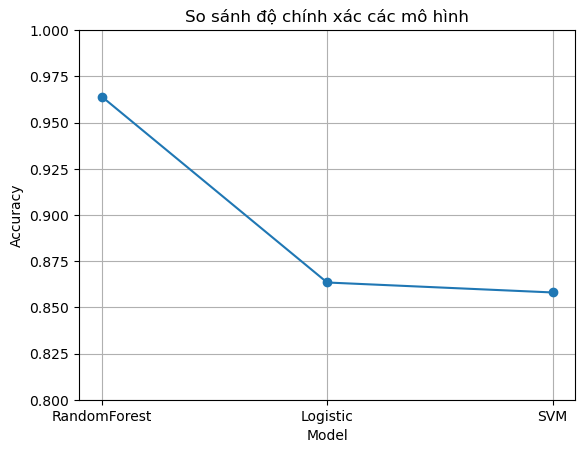

In [66]:
import matplotlib.pyplot as plt

plt.plot(df['Model'], df['Accuracy'], marker='o')
plt.title("So sánh độ chính xác các mô hình")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0.8, 1)
plt.grid(True)
plt.show()



In [103]:
for res in results :
    print(f"Mo hinh cua {res['Model']}")
    print(res['Class_report'])

Mo hinh cua RandomForest
              precision    recall  f1-score   support

       False       0.92      0.82      0.87       158
        True       0.97      0.99      0.98       955

    accuracy                           0.96      1113
   macro avg       0.95      0.90      0.92      1113
weighted avg       0.96      0.96      0.96      1113

Mo hinh cua SVM
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       158
        True       0.86      1.00      0.92       955

    accuracy                           0.86      1113
   macro avg       0.43      0.50      0.46      1113
weighted avg       0.74      0.86      0.79      1113

Mo hinh cua Logistic
              precision    recall  f1-score   support

       False       0.69      0.07      0.13       158
        True       0.87      0.99      0.93       955

    accuracy                           0.86      1113
   macro avg       0.78      0.53      0.53      1113
weighted avg

# Cải tiến Mô hình 

In [105]:
from sklearn.model_selection import GridSearchCV

In [143]:
models = {
     "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(class_weight=None),
    'SVM' : SVC(class_weight= 'balanced'),
    'XGB' : XGBClassifier()
}
grid_params = {
    'Logistic Regression': {
        'C' : [0.01 , 0.1 , 1 , 10]
    },
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10]
    }
}
results = []
for name , model in models.items():
    if name in grid_params : 
        grid = GridSearchCV(model, grid_params[name], cv=5, scoring='accuracy')
        grid.fit(X_train , y_train)
        best_model = grid.best_estimator_
        best_params = grid.best_params_
    else :
        model.fit(X_train , y_train)
        best_model = model 
        best_params = 'N/A'
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    results.append({
            "Model": name,
            "Accuracy": acc,
            "Best Params": best_params , 
            'cm' : cm ,
            'report' : report,
            'model' : best_model
        })


In [144]:
df = pd.DataFrame([{'Model': r['Model'], 'Accuracy': r['Accuracy']} for r in results])
df = df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
print(df)

                 Model  Accuracy
0                  XGB  0.967655
1        Random Forest  0.964061
2  Logistic Regression  0.939802
3                  SVM  0.929919



Mô hình của Logistic Regression


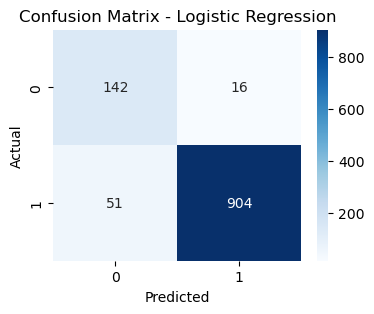

              precision    recall  f1-score   support

       False       0.74      0.90      0.81       158
        True       0.98      0.95      0.96       955

    accuracy                           0.94      1113
   macro avg       0.86      0.92      0.89      1113
weighted avg       0.95      0.94      0.94      1113


Mô hình của Random Forest


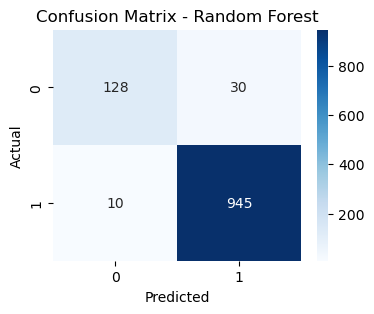

              precision    recall  f1-score   support

       False       0.93      0.81      0.86       158
        True       0.97      0.99      0.98       955

    accuracy                           0.96      1113
   macro avg       0.95      0.90      0.92      1113
weighted avg       0.96      0.96      0.96      1113


Mô hình của SVM


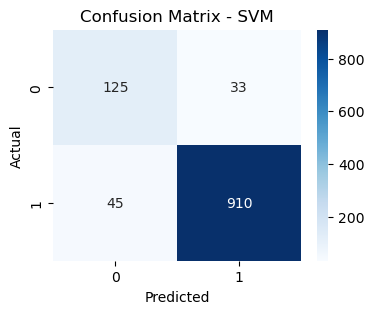

              precision    recall  f1-score   support

       False       0.74      0.79      0.76       158
        True       0.97      0.95      0.96       955

    accuracy                           0.93      1113
   macro avg       0.85      0.87      0.86      1113
weighted avg       0.93      0.93      0.93      1113


Mô hình của XGB


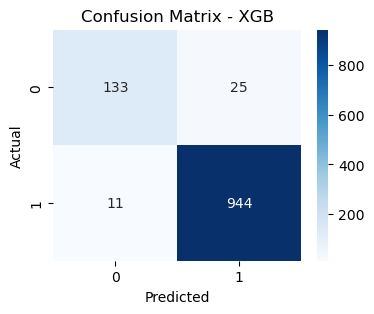

              precision    recall  f1-score   support

       False       0.92      0.84      0.88       158
        True       0.97      0.99      0.98       955

    accuracy                           0.97      1113
   macro avg       0.95      0.92      0.93      1113
weighted avg       0.97      0.97      0.97      1113



In [145]:

for res in results:
    print(f"\nMô hình của {res['Model']}")
    
    plt.figure(figsize=(4, 3))
    sns.heatmap(res['cm'], annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {res['Model']}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    print(res['report'])


In [169]:
import joblib 
for i in range(len(results)):
    final = results[i]['Model']
    if(final == 'Random Forest'):
        joblib.dump(results[i]['model'] , 'best_model.pkl')